In [11]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [77]:
CUR_DIR= os.getcwd()
DATA_DIR = os.path.join(CUR_DIR, "Data")
input_file = os.path.join(DATA_DIR, 'Yash.txt')

In [78]:
def startsWithDateAndTime(s):
    # regex pattern for date
    pattern = '^[0-9]{1,2}/[0-9]{1,2}/[0-9]{1,2}, [0-9]{1,2}:[0-9]{1,2} (AM|PM) -'
    #pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (AM|PM) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [79]:
# Finds username of any given format.
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False
  

In [80]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [81]:
parsedData = []
with open(input_file, encoding="utf-8") as f:
    f.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = f.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [82]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])
df.tail()

,Date,Time,Author,Message
388,2020-12-01,10:56 AM,sushil,Accha
389,2020-12-01,10:56 AM,sushil,Thik he kar dena jab time mila tab
390,2020-12-01,10:57 AM,Yash,Haan aaj karwata hu
391,2020-12-01,10:57 AM,sushil,Ek baar nehul ko bata dena book karne se pehle
392,2020-12-01,10:59 AM,Yash,Haan usse hui baat!


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     393 non-null    datetime64[ns]
 1   Time     393 non-null    object        
 2   Author   392 non-null    object        
 3   Message  393 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 12.4+ KB


In [84]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 1 to 392
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     392 non-null    datetime64[ns]
 1   Time     392 non-null    object        
 2   Author   392 non-null    object        
 3   Message  392 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 15.3+ KB


In [85]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [86]:
total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
df

,Date,Time,Author,Message,emoji,urlcount
1,2018-09-12,8:11 AM,sushil,😍,[😍],0
2,2018-09-12,9:01 AM,Yash,😛,[😛],0
3,2018-09-24,10:43 PM,sushil,ML practice karne ke liye kuch sites bata,[],0
4,2018-09-24,10:44 PM,Yash,Kaggle,[],0
5,2018-09-24,10:44 PM,sushil,Mene wo Andrew ng ka course around 60-70% Kar ...,[],0
...,...,...,...,...,...,...
388,2020-12-01,10:56 AM,sushil,Accha,[],0
389,2020-12-01,10:56 AM,sushil,Thik he kar dena jab time mila tab,[],0
390,2020-12-01,10:57 AM,Yash,Haan aaj karwata hu,[],0
391,2020-12-01,10:57 AM,sushil,Ek baar nehul ko bata dena book karne se pehle,[],0


In [87]:
print("total_messages:",total_messages)
print("media_messages:",media_messages)
print("emoji:",emojis)
print("links",links)

total_messages: 392
media_messages: 42
emoji: 106
links 5


In [88]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)

In [89]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [90]:
messages_df

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count
1,2018-09-12,8:11 AM,sushil,😍,[😍],0,1,1
2,2018-09-12,9:01 AM,Yash,😛,[😛],0,1,1
3,2018-09-24,10:43 PM,sushil,ML practice karne ke liye kuch sites bata,[],0,41,8
4,2018-09-24,10:44 PM,Yash,Kaggle,[],0,6,1
5,2018-09-24,10:44 PM,sushil,Mene wo Andrew ng ka course around 60-70% Kar ...,[],0,50,10
...,...,...,...,...,...,...,...,...
388,2020-12-01,10:56 AM,sushil,Accha,[],0,5,1
389,2020-12-01,10:56 AM,sushil,Thik he kar dena jab time mila tab,[],0,34,8
390,2020-12-01,10:57 AM,Yash,Haan aaj karwata hu,[],0,19,4
391,2020-12-01,10:57 AM,sushil,Ek baar nehul ko bata dena book karne se pehle,[],0,46,10


In [91]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
    # Filtering out messages of particular user
    req_df= messages_df[messages_df["Author"] == l[i]]
    # req_df will contain messages of only one particular user
    print(f'Stats of {l[i]} -')
    # shape will print number of rows which indirectly means the number of messages
    print('Messages Sent', req_df.shape[0])
    #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Words per message', words_per_message)
    #media conists of media messages
    media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
    print('Media Messages Sent', media)
    # emojis conists of total emojis
    emojis = sum(req_df['emoji'].str.len())
    print('Emojis Sent', emojis)
    #links consist of total links
    links = sum(req_df["urlcount"])   
    print('Links Sent', links)   
    print()

Stats of sushil -
Messages Sent 182
Words per message 3.708791208791209
Media Messages Sent 6
Emojis Sent 67
Links Sent 1

Stats of Yash -
Messages Sent 168
Words per message 4.565476190476191
Media Messages Sent 36
Emojis Sent 39
Links Sent 4



In [92]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

18


In [93]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df


,emoji,count
0,😂,69
1,😍,9
2,😛,4
3,👍🏻,4
4,🎉,3
5,🤣,3
6,🙈,2
7,😝,2
8,😁,1
9,🎊,1


In [94]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [95]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
    dummy_df = messages_df[messages_df['Author'] == l[i]]
    total_emojis_list = list([a for b in dummy_df.emoji for a in b])
    emoji_dict = dict(Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    print('Emoji Distribution for', l[i])
    author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
    fig = px.pie(author_emoji_df, values='count', names='emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

Emoji Distribution for sushil


Emoji Distribution for Yash


In [96]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 7397 words in all the messages.


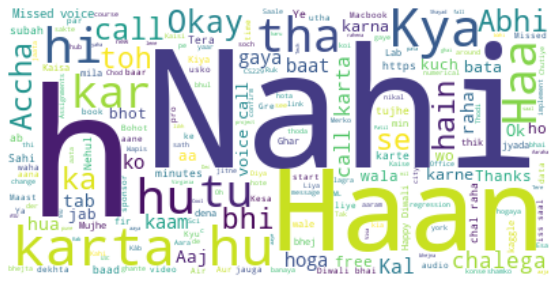

In [97]:
stopwords = set(STOPWORDS)
stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [98]:
messages_df["MessageCount"]=1
messages_df.head(5)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
1,2018-09-12,8:11 AM,sushil,😍,[😍],0,1,1,1
2,2018-09-12,9:01 AM,Yash,😛,[😛],0,1,1,1
3,2018-09-24,10:43 PM,sushil,ML practice karne ke liye kuch sites bata,[],0,41,8,1
4,2018-09-24,10:44 PM,Yash,Kaggle,[],0,6,1,1
5,2018-09-24,10:44 PM,sushil,Mene wo Andrew ng ka course around 60-70% Kar ...,[],0,50,10,1


In [99]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
date_df.head(3)

,Date,urlcount,Letter_Count,Word_Count,MessageCount
0,2018-09-12,0,2,2,2
1,2018-09-24,0,481,94,18
2,2018-09-25,3,427,50,13


In [100]:
fig = px.line(date_df, x="Date", y="MessageCount", title='Number of Messages as time moves on.')
fig.update_xaxes(nticks=20)
fig.show()

Text(0, 0.5, 'Date')

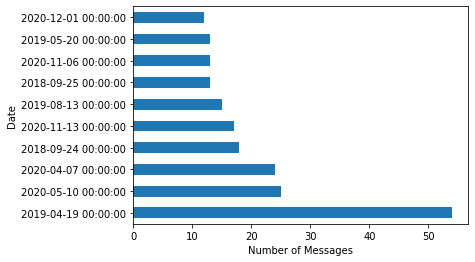

In [101]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')